<a href="https://colab.research.google.com/github/madanmohan-venkatesan/notebooks/blob/main/2011_03567.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [218]:
import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import seaborn as sns

# 2. A sequential multinomial test


In [219]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100

In [220]:
theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
rng = np.random.default_rng()
vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)

In [221]:
K=100
alpha_dirichlet=K*theta_null
rng = np.random.default_rng()
theta_alt=rng.dirichlet(alpha_dirichlet)
vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

In [222]:
s_n_null=np.sum(vectors_null,axis=0)
s_n_alt=np.sum(vectors_alt,axis=0)

In [223]:
#need some exceptions
def beta(v):

  numerator=np.prod(gamma(v))
  denominator=gamma(np.sum(v))
  if numerator.any() is np.nan or denominator.any() is np.nan:
    return [np.inf,np.inf]
  else:
    return numerator/denominator


In [224]:
#need some exceptions
def bf_10(dirichlet_alpha,theta,counts):
  term1_numerator=beta(dirichlet_alpha+counts)
  term1_denominator=beta(dirichlet_alpha)
  term1=term1_numerator/term1_denominator

  term2=1/(theta**counts)
  if term1.any() is np.inf or term2.any() is np.inf:
    return [np.inf,np.inf]
  else:
    return term1*term2


In [225]:
bf_10(alpha_dirichlet,theta_null,s_n_null)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-223-c9ac9219823d>:9: RuntimeWarning: invalid value encountered in scalar divide
  return numerator/denominator


array([nan, nan])

In [226]:
bf_10(alpha_dirichlet,theta_null,s_n_alt)

<ipython-input-223-c9ac9219823d>:9: RuntimeWarning: invalid value encountered in scalar divide
  return numerator/denominator


array([nan, nan])

For above bf_10, if theta_0 not equal theta then values will go to infinity (reject null hypothesis)
otherwise value is zero(accept null hypothesis)

Hyper paramters to play around with are K and vector size



In [227]:
theta_null_arr=[]
theta_alt_arr=[]
dirichlet_alpha_arr=[]
vetors_null_arr=[]
vectors_alt_arr=[]
for i in range(10):
  if i==0:
    K=10
  else:
    K=K#+(0.5*K)
  #generate null vectors
  theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
  rng = np.random.default_rng()
  vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)
  #generate alt vectors

  alpha_dirichlet=K*theta_null
  rng = np.random.default_rng()
  theta_alt=rng.dirichlet(alpha_dirichlet)
  vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

  theta_null_arr.append(theta_null)
  theta_alt_arr.append(theta_alt)
  dirichlet_alpha_arr.append(alpha_dirichlet)
  vetors_null_arr.append(vectors_null)
  vectors_alt_arr.append(vectors_alt)

In [228]:
#give some exceptions
on_theta_hist_arr=[]
for i in range(len(theta_null_arr)):
  on_theta_prev = None
  if i==0:
    on_theta_prev = np.array([1,1])
    on_theta_hist_arr.append(on_theta_prev)

  else:
    s_n_null=np.sum(vetors_null_arr[i],axis=0)
    s_n_alt=np.sum(vectors_alt_arr[i],axis=0)
    term1_numerator=beta(dirichlet_alpha_arr[i]+s_n_alt)
    term1_denominator=beta(dirichlet_alpha_arr[i])
    term1=term1_numerator/term1_denominator

    term2=1/(theta_null_arr[i]**s_n_alt)

    on_theta_hist_arr.append(on_theta_hist_arr[i-1]*term1*term2)

In [229]:
on_theta_hist_arr=np.array(on_theta_hist_arr)
on_theta_hist_arr

array([[1.00000000e+000, 1.00000000e+000],
       [5.01328333e-012, 1.19525989e-018],
       [1.90934921e-007, 1.54236001e-034],
       [1.79634815e-024, 1.67297959e-033],
       [9.05040784e-042, 1.38098264e-046],
       [6.37441981e-058, 1.55625484e-061],
       [1.66875307e-073, 4.07410418e-077],
       [8.19361044e-084, 2.98081811e-095],
       [5.77095681e-100, 3.35913897e-110],
       [3.24287075e-114, 7.37343441e-127]])

In [230]:
np.where(on_theta_hist_arr<(1/0.05),on_theta_hist_arr,np.inf)

array([[1.00000000e+000, 1.00000000e+000],
       [5.01328333e-012, 1.19525989e-018],
       [1.90934921e-007, 1.54236001e-034],
       [1.79634815e-024, 1.67297959e-033],
       [9.05040784e-042, 1.38098264e-046],
       [6.37441981e-058, 1.55625484e-061],
       [1.66875307e-073, 4.07410418e-077],
       [8.19361044e-084, 2.98081811e-095],
       [5.77095681e-100, 3.35913897e-110],
       [3.24287075e-114, 7.37343441e-127]])

# Optimization problem for theta

In [231]:
on_theta_hist_arr_=on_theta_hist_arr[on_theta_hist_arr<(1/0.05)].reshape(-1,2)

In [232]:
def objective(theta, i,maximize=True):
    """
    Objective function to maximize theta_i.

    Parameters:
    - theta (array): Probability vector (simplex).
    - i (int): Index of the element to maximize.

    Returns:
    - float: Negative of theta[i] to convert minimization to maximization.
    """
    if maximize:
        return -theta[i]
    else:
      return theta[i]

def constraint_sum(theta):
    """
    Constraint ensuring that the sum of theta is 1.

    Parameters:
    - theta (array): Probability vector (simplex).

    Returns:
    - float: Sum of theta - 1 (should be 0).
    """
    return np.sum(theta) - 1

def constraint_log_likelihood(theta, Sn, c):
    """
    Log-likelihood constraint.

    Parameters:
    - theta (array): Probability vector (simplex).
    - Sn (array): Observed count vector S_{n,i}.
    - c (float): Constant c + log u.

    Returns:
    - float: Left-hand side of the constraint.
    """
    return np.sum(Sn * np.log(theta)) - c

# Example data
Sn = np.sum(vectors_alt_arr[i],axis=0)  # Example counts for categories
c = np.log(beta(dirichlet_alpha_arr[-1]+np.sum(vectors_alt_arr[i],axis=0))) - np.log(beta(dirichlet_alpha_arr[-1]))  # Example constant for log Beta terms
u = 0.05  # Example confidence level
c += np.log(u)

# Initial guess for theta (uniform distribution)
initial_theta = np.full(len(Sn), 1 / len(Sn))

# Constraints
constraints = [
    {'type': 'eq', 'fun': constraint_sum},
    {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (Sn, c)}
]

# Index of theta to maximize
i = 0  # Change this to select a different element of theta

# Bounds to ensure theta remains within [0, 1]
bounds = [(0, 1) for _ in range(len(Sn))]

# Solve the optimization problem
result = minimize(objective, initial_theta, args=(i,True), bounds=bounds, constraints=constraints, method='SLSQP')

# Display the result
if result.success:
    print("Optimal theta:", result.x)
    print(f"Maximized theta[{i}]:", result.x[i])
else:
    print("Optimization failed:", result.message)

Optimal theta: [0.67997668 0.32002332]
Maximized theta[0]: 0.6799766827729306


# Real simulation

In [233]:
theta_null_arr=[]
theta_alt_arr=[]
dirichlet_alpha_arr=[]
vetors_null_arr=[]
vectors_alt_arr=[]
on_theta_hist_arr=[]
theta_alt_1max_arr=[]
theta_alt_1min_arr=[]

theta_alt_0max_arr=[]
theta_alt_0min_arr=[]

for i in range(100):
  on_theta_prev = None
  if i==0:
    K=10
    on_theta_prev = np.array([1,1])
    #generate null vectors
    theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
    rng = np.random.default_rng()
    vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)
    #generate alt vectors

    alpha_dirichlet=K*theta_null
    rng = np.random.default_rng()
    theta_alt=rng.dirichlet(alpha_dirichlet)
    vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

    theta_null_arr.append(theta_null)
    theta_alt_arr.append(theta_alt)
    dirichlet_alpha_arr.append(alpha_dirichlet)
    vetors_null_arr.append(vectors_null)
    vectors_alt_arr.append(vectors_alt)

    on_theta_prev = np.array([1,1])
    on_theta_hist_arr.append(on_theta_prev)

    s_n_null=np.sum(vectors_null,axis=0)
    s_n_alt=np.sum(vectors_alt,axis=0)

    c = np.log(beta(alpha_dirichlet+s_n_alt)) - np.log(beta(alpha_dirichlet))  # Example constant for log Beta terms
    u = 0.05  # Example confidence level
    c += np.log(u)

    # Initial guess for theta (uniform distribution)
    initial_theta = np.full(len(s_n_alt), 1 / len(s_n_alt))

    # Constraints
    constraints = [
        {'type': 'eq', 'fun': constraint_sum},
        {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
    ]

    # Index of theta to maximize
    i = 0  # Change this to select a different element of theta

    # Bounds to ensure theta remains within [0, 1]
    bounds = [(0, 1) for _ in range(len(s_n_alt))]

    # Solve the optimization problem
    result0 = minimize(objective, initial_theta, args=(0,True), bounds=bounds, constraints=constraints, method='SLSQP')
    result1 = minimize(objective, initial_theta, args=(1,True), bounds=bounds, constraints=constraints, method='SLSQP')

    # Display the result
    if result0.success:
        theta_alt_0max_arr.append(result0.x[0])
    else:
        print("Optimization failed:", result0.message)

    if result1.success:
        theta_alt_1max_arr.append(result1.x[0])
    else:
        print("Optimization failed:", result1.message)




    # Solve the optimization problem

    result0 = minimize(objective, initial_theta, args=(0,False), bounds=bounds, constraints=constraints, method='SLSQP')
    result1 = minimize(objective, initial_theta, args=(1,False), bounds=bounds, constraints=constraints, method='SLSQP')

    # Display the result
    if result0.success:
        theta_alt_0min_arr.append(result0.x[0])
    else:
        print("Optimization failed:", result0.message)

    if result1.success:
        theta_alt_1min_arr.append(result1.x[0])
    else:
        print("Optimization failed:", result1.message)

  else:

    K=K#+(0.5*K)

    #generate null vectors
    theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
    rng = np.random.default_rng()
    vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)
    #generate alt vectors

    alpha_dirichlet=K*theta_null
    rng = np.random.default_rng()
    theta_alt=rng.dirichlet(alpha_dirichlet)
    vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

    theta_null_arr.append(theta_null)
    theta_alt_arr.append(theta_alt)
    dirichlet_alpha_arr.append(alpha_dirichlet)
    vetors_null_arr.append(vectors_null)
    vectors_alt_arr.append(vectors_alt)

    s_n_null=np.sum(vectors_null,axis=0)
    s_n_alt=np.sum(vectors_alt,axis=0)
    term1_numerator=beta(alpha_dirichlet+s_n_alt)
    term1_denominator=beta(alpha_dirichlet)
    term1=term1_numerator/term1_denominator

    term2=1/(theta_null**s_n_alt)

    on_theta_hist_arr.append(on_theta_hist_arr[i-1]*term1*term2)

    # Example data
    # Sn = np.sum(vectors_alt_arr[i],axis=0)  # Example counts for categories
    c = np.log(beta(alpha_dirichlet+s_n_alt)) - np.log(beta(alpha_dirichlet))  # Example constant for log Beta terms
    u = 0.05  # Example confidence level
    c += np.log(u)

    # Initial guess for theta (uniform distribution)
    initial_theta = np.full(len(s_n_alt), 1 / len(s_n_alt))

    # Constraints
    constraints = [
        {'type': 'eq', 'fun': constraint_sum},
        {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
    ]

    # Index of theta to maximize
    i = 0  # Change this to select a different element of theta

    # Bounds to ensure theta remains within [0, 1]
    bounds = [(0, 1) for _ in range(len(s_n_alt))]

    # Solve the optimization problem
    result0 = minimize(objective, initial_theta, args=(0,True), bounds=bounds, constraints=constraints, method='SLSQP')
    result1 = minimize(objective, initial_theta, args=(1,True), bounds=bounds, constraints=constraints, method='SLSQP')

    # Display the result
    if result0.success:
        theta_alt_0max_arr.append(result0.x[0])
    else:
        print("Optimization failed:", result0.message)

    if result1.success:
        theta_alt_1max_arr.append(result1.x[0])
    else:
        print("Optimization failed:", result1.message)




    # Solve the optimization problem

    result0 = minimize(objective, initial_theta, args=(0,False), bounds=bounds, constraints=constraints, method='SLSQP')
    result1 = minimize(objective, initial_theta, args=(1,False), bounds=bounds, constraints=constraints, method='SLSQP')

    # Display the result
    if result0.success:
        theta_alt_0min_arr.append(result0.x[0])
    else:
        print("Optimization failed:", result0.message)

    if result1.success:
        theta_alt_1min_arr.append(result1.x[0])
    else:
        print("Optimization failed:", result1.message)

In [234]:
theta_alt_arr

[array([0.62474102, 0.37525898]),
 array([0.75089782, 0.24910218]),
 array([0.20042353, 0.79957647]),
 array([0.57929032, 0.42070968]),
 array([0.51418062, 0.48581938]),
 array([0.38628436, 0.61371564]),
 array([0.55790852, 0.44209148]),
 array([0.76903916, 0.23096084]),
 array([0.35277794, 0.64722206]),
 array([0.60838773, 0.39161227]),
 array([0.30212895, 0.69787105]),
 array([0.61985989, 0.38014011]),
 array([0.77515031, 0.22484969]),
 array([0.44981037, 0.55018963]),
 array([0.32169448, 0.67830552]),
 array([0.36338456, 0.63661544]),
 array([0.53769684, 0.46230316]),
 array([0.50752636, 0.49247364]),
 array([0.49187174, 0.50812826]),
 array([0.57206438, 0.42793562]),
 array([0.52011082, 0.47988918]),
 array([0.67067816, 0.32932184]),
 array([0.5665121, 0.4334879]),
 array([0.34205764, 0.65794236]),
 array([0.55641947, 0.44358053]),
 array([0.45728347, 0.54271653]),
 array([0.30709928, 0.69290072]),
 array([0.67334328, 0.32665672]),
 array([0.49983894, 0.50016106]),
 array([0.544165

In [235]:
on_theta_hist_arr

[array([1, 1]),
 array([7.19389020e-03, 1.59736451e-18]),
 array([4.02865121e-20, 2.57833677e-18]),
 array([4.79287771e-27, 1.11592880e-36]),
 array([2.69325927e-41, 2.44950504e-53]),
 array([3.21914478e-59, 1.22800628e-64]),
 array([4.26908034e-73, 1.59035636e-81]),
 array([4.63062074e-72, 1.49623426e-98]),
 array([2.42324164e-090, 8.40730833e-108]),
 array([1.82651095e-098, 3.68860949e-126]),
 array([1.27698432e-116, 1.81470386e-130]),
 array([2.07981089e-126, 1.10104272e-148]),
 array([8.65654591e-128, 2.54393020e-166]),
 array([6.86378503e-145, 8.26198070e-180]),
 array([3.22347734e-163, 1.66649872e-188]),
 array([1.62670011e-181, 3.69868783e-194]),
 array([8.15510855e-193, 4.42089320e-212]),
 array([4.58233807e-202, 2.31348951e-230]),
 array([1.48821649e-215, 1.83436844e-247]),
 array([4.83331495e-229, 1.45447281e-264]),
 array([1.56972682e-242, 1.15325313e-281]),
 array([1.86750064e-249, 4.99138981e-300]),
 array([2.48972345e-265, 0.00000000e+000]),
 array([1.06281479e-283, 0.000

[]

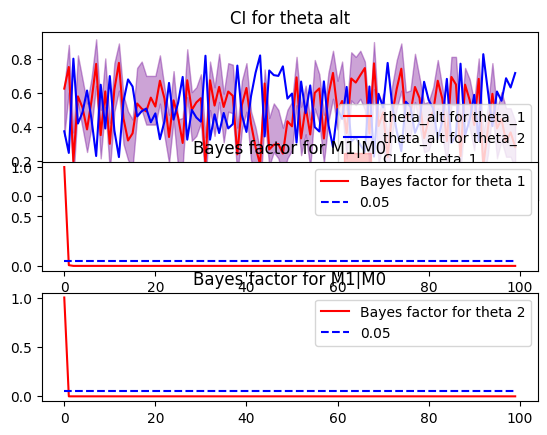

In [236]:
plt.subplot(2,1,1)
plt.title("CI for theta alt")
plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_arr)[:,0],color='r',label="theta_alt for theta_1")
plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_arr)[:,1],color='b',label="theta_alt for theta_2")

plt.fill_between(range(len(theta_alt_arr)),
                 np.array(theta_alt_0min_arr),
                 np.array(theta_alt_0max_arr), color='r',
                 alpha=0.2, label="CI for theta_1")  # alpha controls transparency


plt.fill_between(range(len(theta_alt_arr)),
                 np.array(theta_alt_1min_arr),
                 np.array(theta_alt_1max_arr), color='b',
                 alpha=0.2, label="CI for theta_2")  # alpha controls transparency


# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_min_arr)[:,0],label="theta_alt min for theta_1")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_max_arr)[:,0],label="theta_alt max for theta_1")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_min_arr)[:,1],label="theta_alt min for theta_2")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_max_arr)[:,1],label="theta_alt max for theta_2")

plt.legend()
plt.subplot(3,1,2)
plt.title("Bayes factor for M1|M0")
plt.plot(range(len(theta_alt_arr)),np.array(on_theta_hist_arr)[:,0],color='r',label="Bayes factor for theta 1")
plt.plot(range(len(theta_alt_arr)),[0.05]*len(theta_alt_arr),'--',color='b',label="0.05")
plt.legend()
plt.plot()


plt.subplot(3,1,3)
plt.title("Bayes factor for M1|M0")
plt.plot(range(len(theta_alt_arr)),np.array(on_theta_hist_arr)[:,1],color='r',label="Bayes factor for theta 2")
plt.plot(range(len(theta_alt_arr)),[0.05]*len(theta_alt_arr),'--',color='b',label="0.05")
plt.legend()
plt.plot()

In [237]:
np.round(theta_alt_0min_arr,3)

array([0.348, 0.603, 0.095, 0.537, 0.396, 0.254, 0.405, 0.641, 0.217,
       0.518, 0.146, 0.49 , 0.613, 0.301, 0.208, 0.163, 0.462, 0.499,
       0.415, 0.415, 0.415, 0.537, 0.348, 0.19 , 0.443, 0.163, 0.172,
       0.575, 0.32 , 0.348, 0.424, 0.072, 0.499, 0.348, 0.546, 0.311,
       0.49 , 0.481, 0.12 , 0.386, 0.49 , 0.208, 0.12 , 0.021, 0.452,
       0.172, 0.254, 0.217, 0.12 , 0.217, 0.264, 0.528, 0.236, 0.358,
       0.163, 0.509, 0.424, 0.19 , 0.433, 0.565, 0.386, 0.499, 0.217,
       0.556, 0.528, 0.565, 0.499, 0.163, 0.622, 0.181, 0.311, 0.072,
       0.358, 0.509, 0.613, 0.32 , 0.329, 0.546, 0.405, 0.254, 0.264,
       0.348, 0.509, 0.348, 0.181, 0.528, 0.528, 0.146, 0.462, 0.396,
       0.264, 0.518, 0.095, 0.236, 0.49 , 0.217, 0.32 , 0.227, 0.227,
       0.154])

In [238]:
np.round(theta_alt_1min_arr,3)

array([0.633, 0.88 , 0.368, 0.819, 0.68 , 0.538, 0.689, 0.913, 0.501,
       0.801, 0.425, 0.773, 0.888, 0.585, 0.491, 0.444, 0.746, 0.783,
       0.699, 0.699, 0.699, 0.819, 0.633, 0.472, 0.727, 0.444, 0.454,
       0.854, 0.604, 0.633, 0.708, 0.34 , 0.783, 0.633, 0.828, 0.595,
       0.773, 0.764, 0.397, 0.671, 0.773, 0.491, 0.397, 0.262, 0.736,
       0.454, 0.538, 0.501, 0.397, 0.501, 0.548, 0.81 , 0.519, 0.642,
       0.444, 0.792, 0.708, 0.472, 0.718, 0.846, 0.671, 0.783, 0.501,
       0.837, 0.81 , 0.846, 0.783, 0.444, 0.897, 0.463, 0.595, 0.34 ,
       0.642, 0.792, 0.888, 0.604, 0.614, 0.828, 0.689, 0.538, 0.548,
       0.633, 0.792, 0.633, 0.463, 0.81 , 0.81 , 0.425, 0.746, 0.68 ,
       0.548, 0.801, 0.368, 0.519, 0.773, 0.501, 0.604, 0.51 , 0.51 ,
       0.435])

In [239]:
np.round(theta_alt_1max_arr,3)

array([0.348, 0.603, 0.095, 0.537, 0.396, 0.254, 0.405, 0.641, 0.217,
       0.518, 0.146, 0.49 , 0.613, 0.301, 0.208, 0.163, 0.462, 0.499,
       0.415, 0.415, 0.415, 0.537, 0.348, 0.19 , 0.443, 0.163, 0.172,
       0.575, 0.32 , 0.348, 0.424, 0.072, 0.499, 0.348, 0.546, 0.311,
       0.49 , 0.481, 0.12 , 0.386, 0.49 , 0.208, 0.12 , 0.021, 0.452,
       0.172, 0.254, 0.217, 0.12 , 0.217, 0.264, 0.528, 0.236, 0.358,
       0.163, 0.509, 0.424, 0.19 , 0.433, 0.565, 0.386, 0.499, 0.217,
       0.556, 0.528, 0.565, 0.499, 0.163, 0.622, 0.181, 0.311, 0.072,
       0.358, 0.509, 0.613, 0.32 , 0.329, 0.546, 0.405, 0.254, 0.264,
       0.348, 0.509, 0.348, 0.181, 0.528, 0.528, 0.146, 0.462, 0.396,
       0.264, 0.518, 0.095, 0.236, 0.49 , 0.217, 0.32 , 0.227, 0.227,
       0.154])

In [240]:
np.round(theta_alt_0max_arr,3)

array([0.633, 0.88 , 0.368, 0.819, 0.68 , 0.538, 0.689, 0.913, 0.501,
       0.801, 0.425, 0.773, 0.888, 0.585, 0.491, 0.444, 0.746, 0.783,
       0.699, 0.699, 0.699, 0.819, 0.633, 0.472, 0.727, 0.444, 0.454,
       0.854, 0.604, 0.633, 0.708, 0.34 , 0.783, 0.633, 0.828, 0.595,
       0.773, 0.764, 0.397, 0.671, 0.773, 0.491, 0.397, 0.262, 0.736,
       0.454, 0.538, 0.501, 0.397, 0.501, 0.548, 0.81 , 0.519, 0.642,
       0.444, 0.792, 0.708, 0.472, 0.718, 0.846, 0.671, 0.783, 0.501,
       0.837, 0.81 , 0.846, 0.783, 0.444, 0.897, 0.463, 0.595, 0.34 ,
       0.642, 0.792, 0.888, 0.604, 0.614, 0.828, 0.689, 0.538, 0.548,
       0.633, 0.792, 0.633, 0.463, 0.81 , 0.81 , 0.425, 0.746, 0.68 ,
       0.548, 0.801, 0.368, 0.519, 0.773, 0.501, 0.604, 0.51 , 0.51 ,
       0.435])